In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

### 1a) les inn og forstå dataene

In [15]:
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

df = pd.read_csv(url)

In [16]:
df[:10]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
7,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,...,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
8,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,...,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
9,13,bo bradac,bo,bradac,2013-11-04,Male,1994-06-10,21,Less than 25,Caucasian,...,5,Medium,2013-11-04,2015-01-06,2015-01-07,1,0,428,1,1


In [17]:
df.columns
df_select = df[["id", "name", "sex", "dob", "age", "race", "two_year_recid", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree", "is_recid", "r_charge_degree", "is_violent_recid", "v_decile_score", "score_text" ]]

df_select

,id,name,sex,dob,age,race,two_year_recid,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,is_recid,r_charge_degree,is_violent_recid,v_decile_score,score_text
0,1,miguel hernandez,Male,1947-04-18,69,Other,0,0,0,0,0,F,0,NaN,0,1,Low
1,3,kevon dixon,Male,1982-01-22,34,African-American,1,0,0,0,0,F,1,(F3),1,1,Low
2,4,ed philo,Male,1991-05-14,24,African-American,1,0,0,1,4,F,1,(M1),0,3,Low
3,5,marcu brown,Male,1993-01-21,23,African-American,0,0,1,0,1,F,0,NaN,0,6,High
4,6,bouthy pierrelouis,Male,1973-01-22,43,Other,0,0,0,0,2,F,0,NaN,0,1,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,Male,1992-07-17,23,African-American,0,0,0,0,0,F,0,NaN,0,5,Medium
7210,10997,malcolm simmons,Male,1993-03-25,23,African-American,0,0,0,0,0,F,0,NaN,0,5,Low
7211,10999,winston gregory,Male,1958-10-01,57,Other,0,0,0,0,0,F,0,NaN,0,1,Low
7212,11000,farrah jean,Female,1982-11-17,33,African-American,0,0,0,0,3,M,0,NaN,0,2,Low


*Hvilke kolonner skal vi velge?*

id, name, sex, dob, age, race, two_year_recid, , juv_fel_count, juv_misd_count, juv_other_count
priors_count, c_charge_degree, is_recid, r_charge_degree, is_violent_recid, v_decile_score, 

Kanskje:
compas_screening_date, days_b_screening_arrest, type_of_assessment 

### Kolonnenes betydning

- **id:** ID-nummer.

- **name:** kandidatens fulle navn.

- **first:** fornavn.

- **last:** etternavn.

- **compas_screening_date:** dato for undersøkelse.

- **sex:** kjønn.

- **dob:** fødselsdato.

- **age:** alder.

- **age_cat:** alderkategori.

- **v_decile_score:**

- **v_score_text:**

- **v_screening_date:**

- **in_custody:** dato for ivaretektsfengsling

- **out_custody:** dato for løslatelse

- **priors_count.1:**

- **start:**

- **end:**

- **event:**

- **two_year_recid:** hvorvidt kandidaten begikk et nytt lovbrudd innen to år

#### 
#### 
- Hvor ofte ulike grupperinger av mennesker (kvinner, menn, hvite og svarte) gjentar forbrytelser og blir predikert til å begå straffbare handlinger i framtiden (som andel, ikke totalt antall):

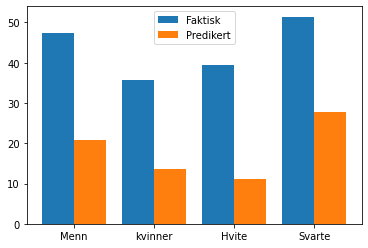

In [18]:
df_male = df_select[df_select["sex"] == "Male"]
df_female = df_select[df_select["sex"] == "Female"]
df_white = df_select[df_select["race"] == "Caucasian"]
df_black = df_select[df_select["race"] == "African-American"]
# two_year_recid

#prosent av gruppen som begår en forbrytelse på nytt innen to år
male_recid = df_male[df_male["two_year_recid"]==1].size/df_male.size*100
female_recid = df_female[df_female["two_year_recid"]==1].size/df_female.size*100
white_recid = df_white[df_white["two_year_recid"]==1].size/df_white.size*100
black_recid = df_black[df_black["two_year_recid"]==1].size/df_black.size*100
"----"
#velger nivå high som at de predikeres til å begå forbrytelese
male_pred = round(df_male[df_male["score_text"] == "High"].size/df_male.size*100, 3)
female_pred = round(df_female[df_female["score_text"] == "High"].size/df_female.size*100, 3)
white_pred = round(df_white[df_white["score_text"] == "High"].size/df_white.size*100, 3)
black_pred = round(df_black[df_black["score_text"] == "High"].size/df_black.size*100, 3)


labels = ["Menn", "kvinner", "Hvite", "Svarte"]
x = np.arange(len(labels))
# y = { "Faktisk" :[male_recid, female_recid, white_recid, black_recid], "Predikert":[male_pred, female_pred, white_pred, black_pred] }

y1 =  [male_recid, female_recid, white_recid, black_recid]
y2 = [male_pred, female_pred, white_pred, black_pred]
width = 0.40

plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.xticks(x, labels)
plt.legend(['Faktisk', 'Predikert'])



#### 
#### 
- Hvor ofte ulike grupper fikk ulike risikoskårer:

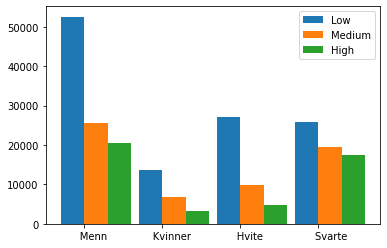

In [19]:
low = {"Low_male" : df_male[df_male["score_text"] == "Low"].size,
       "Low_female" : df_female[df_female["score_text"] == "Low"].size,
       "Low_white" : df_white[df_white["score_text"] == "Low"].size,
       "Low_black" : df_black[df_black["score_text"] == "Low"].size}

medium = {"Medium_male" : df_male[df_male["score_text"] == "Medium"].size,
          "Medium_female" : df_female[df_female["score_text"] == "Medium"].size,
          "Medium_white" : df_white[df_white["score_text"] == "Medium"].size,
          "Medium_black" : df_black[df_black["score_text"] == "Medium"].size}

high = {"High_male" : df_male[df_male["score_text"] == "High"].size,
       "High_female" : df_female[df_female["score_text"] == "High"].size,
       "High_white" : df_white[df_white["score_text"] == "High"].size,
       "High_black" : df_black[df_black["score_text"] == "High"].size}


col_labs = ["Low", "Medium", "High", "h"]
x_labs = ["      Menn", "      Kvinner", "      Hvite" ,"        Svarte"]
x = np.arange(len(col_labs))
width = 0.30

plt.bar(x-0.15, low.values(), width)
plt.bar(x+0.15, medium.values(), width)
plt.bar(x+0.45, high.values(), width)

plt.xticks(x, x_labs)
plt.legend(col_labs)

#### 
#### 
- Hvor ofte de som begikk nye straffbare handlinger (og de som ikke gjorde det) fikk ulike risikoskårer:

55267 6834
62832


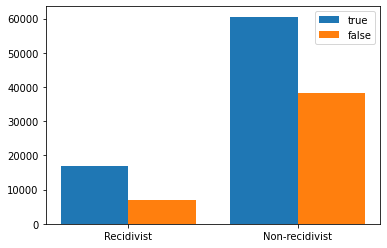

In [34]:
# hvor ofte de som begikk nye straffbare hadlinger (og de som ikke gjorde det) fikk ulike risikoskårer, og hvordan 
# dette ser ut hvis du kun ser på hvite eller svarte.

gold_pos = df_select[df_select["two_year_recid"] == 1]
gold_neg = df_select[df_select["two_year_recid"] == 0]

true_pos = gold_pos[gold_pos["score_text"] == "High"]
false_pos = gold_neg[gold_neg["score_text"] == "High"]

true_neg = gold_neg[gold_neg["score_text"] == "Low"] + gold_neg[gold_neg["score_text"] == "Medium"]
false_neg = gold_pos[gold_pos["score_text"] == "Low"] + gold_pos[gold_pos["score_text"] == "Medium"]

print(gold_pos.size, false_pos.size)
print(df_black.size)
col_labs = ["true", "false"]
x_labs = ["Recidivist", "Non-recidivist"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.20, [true_pos.size, true_neg.size], width)
plt.bar(x+0.20, [false_pos.size, false_neg.size], width)

plt.xticks(x, x_labs)
plt.legend(col_labs)

#### 
#### 
- Hvordan de som begikk nye straffbare handlinger (og de som ikke gjorde det) fikk ulike risikoskårer - hvite versus svarte:

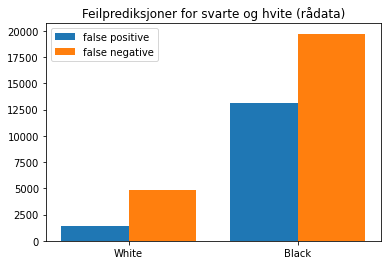

In [35]:
gold_pos_white = gold_pos[gold_pos["race"] == "Caucasian"]
gold_pos_black = gold_pos[gold_pos["race"] == "African-American"]

gold_neg_white = gold_neg[gold_neg["race"] == "Caucasian"]
gold_neg_black = gold_neg[gold_neg["race"] == "African-American"]

#true_pos_white = gold_pos_white[gold_pos_white["score_text"] == "High"]
#true_pos_black = gold_pos_black[gold_pos_black["score_text"] == "High"]
#true_neg_white = gold_neg_white[gold_neg_white["score_text"] == "Low"] + gold_neg_white[gold_neg_white["score_text"] == "Medium"]
#true_neg_black = gold_neg_black[gold_neg_black["score_text"] == "Low"] + gold_neg_black[gold_neg_black["score_text"] == "Medium"]

false_pos_white = gold_neg_white[gold_neg_white["score_text"] == "High"]
false_pos_black = gold_neg_black[gold_neg_black["score_text"] == "High"]

false_neg_white = gold_pos_white[gold_pos_white["score_text"] == "Low"] + gold_pos_white[gold_pos_white["score_text"] == "Medium"]
false_neg_black = gold_pos_black[gold_pos_black["score_text"] == "Low"] + gold_pos_black[gold_pos_black["score_text"] == "Medium"]

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [false_pos_white.size, false_neg_white.size], width)
plt.bar(x+0.2, [false_pos_black.size, false_neg_black.size], width)

plt.xticks(x, x_labs)
plt.title("Feilprediksjoner for svarte og hvite (rådata)")
plt.legend(col_labs)

3.3007334963325183
31.41809290953545
7.683982683982683
31.38528138528138


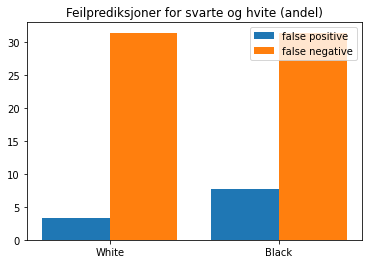

In [36]:
pos_white_ratio = false_pos_white.size / df_white.size * 100
pos_black_ratio = false_pos_black.size / df_black.size * 100
neg_white_ratio = false_neg_white.size / df_white.size * 100
neg_black_ratio = false_neg_black.size / df_black.size * 100

print(pos_white_ratio)
print(neg_white_ratio)
print(pos_black_ratio)
print(neg_black_ratio)

col_labs = ["false positive", "false negative"]
x_labs = ["White", "Black"]
x = np.arange(len(col_labs))
width = 0.4

plt.bar(x-0.2, [pos_white_ratio, pos_black_ratio], width)
plt.bar(x+0.2, [neg_white_ratio, neg_black_ratio], width)

plt.xticks(x, x_labs)
plt.title("Feilprediksjoner for svarte og hvite (andel)")
plt.legend(col_labs)

### 1 d)

In [9]:
# plotter "partial dependence"
features = ["priors_count" '''flere parametre her''']

PartialDependenceDisplay.from_estimator('''klassifikator her''', df_select, features)

plt.gcf().set_size_inches(15, 10)
plt.show()

TypeError: two_year_recid is not an estimator instance.